In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import scipy
from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import os
import keras.models
from sklearn.metrics import r2_score, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:

train_data = pd.read_csv("d:/Downloads/Vodafone Music Challenge/Data/train_music.csv", sep=',')
# print(train_data.info())
# print(train_data.sample(5))
# print(train_data.describe())
# print(pd.isnull(train_data))



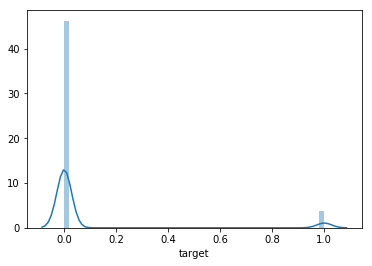

In [4]:
# undersample 0 class
sns.distplot(train_data['target'])

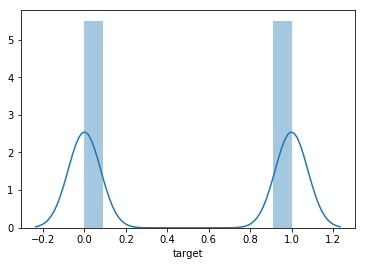

In [5]:
target_one_count = len(train_data[train_data['target'] == 1])
target_zero_indices = train_data[train_data.target == 0].index
target_zero_random_indices = np.random.choice(target_zero_indices, target_one_count, replace=False)
target_one_indices = train_data[train_data.target == 1].index
under_sample_indices = np.concatenate([target_one_indices, target_zero_random_indices])
train_data = train_data.loc[under_sample_indices]

sns.distplot(train_data['target'])

In [6]:
# split_to_train_test_sets
x = train_data.iloc[:, 2:train_data.shape[1]]
y = np.ravel(train_data.target)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)


In [7]:
# find first columns with the best correlation
corframe = pd.DataFrame(columns=["ColName", "Corr", "NullCount", "Mean"])
line_count = x_train.index.size

for column in x_train:
    nas = np.logical_or(np.isnan(x_train[column].values), np.isnan(y_train))
    cor = abs(scipy.stats.stats.pearsonr(x_train[column].values[~nas], y_train[~nas])[0])
    # not to use columns with many nulls, more than 10%
    null_count = np.isnan(x_train[column].values).sum()
    if (null_count / line_count > 0.1):
        continue
    mean = x_train.loc[:, column].mean()
    df = pd.DataFrame([[column, cor, null_count, mean]], columns=["ColName", "Corr", "NullCount", "Mean"])
    corframe = corframe.append(df, ignore_index=True)

corframe = corframe.sort_values(by="Corr", ascending=False)
print(corframe.iloc[0:5, :])

# fill nan with mean
df_mean = x_train.mean()
x_train.fillna(df_mean, inplace=True)
x_test.fillna(df_mean, inplace=True)

D:\work\vodafone_music_classificator\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


                ColName      Corr NullCount       Mean
5                    lt  0.349129         0   0.744138
140    content_count_m1  0.222507       198  61.695279
368    content_count_m3  0.192362       642  59.035551
255    content_count_m2  0.189489       440  60.709354
21   count_sms_source_5  0.130418       701   0.584077


D:\work\vodafone_music_classificator\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [8]:
def get_model(x_train, y_train):
    model_path = './vod_music_model.h5'
    print(os.path.abspath(model_path))
    if os.path.isfile(model_path):
        model = keras.models.load_model(model_path);
    else:
        model = Sequential()

        # Add an input layer
        model.add(Dense(x_train.shape[1], activation='relu', input_shape=(x_train.shape[1],)))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.output_shape
        model.summary()
        model.get_config()
        model.get_weights()

        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(x_train, y_train, epochs=10, batch_size=10, verbose=1, validation_split=0.5)
        model.save(model_path)
    return model

def train(x_train, y_train):
    model = get_model(x_train, y_train)
    return model


In [9]:
# the count of most important features we will use
n_features = 4
model = train(x_train[corframe.values[0:n_features, 0]], y_train)
y_pred = model.predict(x_test[corframe.values[0:n_features, 0]])
cor_test = scipy.stats.stats.pearsonr(y_test, np.transpose(y_pred.round())[0])[0]
print("test-pred correlation: " + str(cor_test))
score = model.evaluate(x_test[corframe.values[0:n_features, 0]], y_test, verbose=1)
print("score" + str(score))


D:\work\vodafone_music_classificator\vod_music_model.h5


test-pred correlation: 0.1785763991357038
  32/3181 [..............................] - ETA: 3s

1216/3181 [==========>...................] - ETA: 0s

2464/3181 [======================>.......] - ETA: 0s

3181/3181 [==============================] - 0s 52us/step


score[0.6886567463480575, 0.5894372839011025]


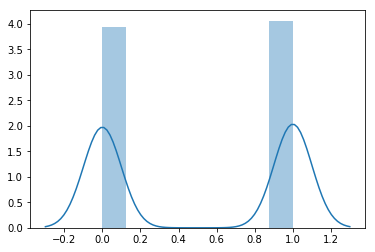

In [10]:
sns.distplot(np.transpose(y_test))


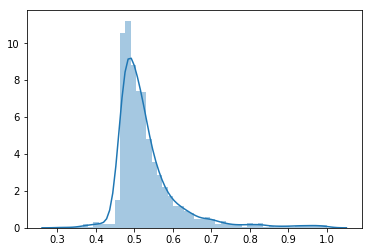

In [11]:
sns.distplot(np.transpose(y_pred)[0])


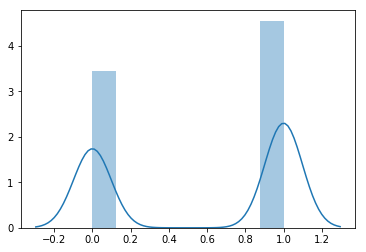

In [12]:
sns.distplot(np.transpose(y_pred.round())[0])
